In [1]:
import scanpy as sc
from anndata import read_h5ad
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os.path import join
import time

# scTRS tools
import scTRS.util as util
import scTRS.data_loader as dl
import scTRS.method as md

# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
# File paths
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
FIG_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/results/fig_hep'
DS_LIST = ['xin']

# Score files
DIC_SCORE_PATH = {'xin': DATA_PATH+'/score_file/score.xin_with_cov.magma_10kb_1000'}
# DIC_SCORE_PATH = {'xin': DATA_PATH+'/score_file/score.xin_with_cov.pancreas_xin_2018'}

DIC_TRAIT_LIST = {}
DIC_TRAIT_LIST = {'xin': ['PASS_Type_2_Diabetes', 'PASS_Intelligence_SavageJansen2018']}
# DIC_TRAIT_LIST['xin'] = ['UPR', 'Apoptosis', 'Senescence', 'Cell_cycle_G1S', 'Cell_cycle_G2M',
#                                'Beta_sub1', 'Beta_sub2', 'Beta_sub3', 'Beta_sub4']

In [3]:
# Load raw data 
dic_data_raw = {}
# dic_data_raw['facs'] = dl.load_tms_ct(DATA_PATH, data_name='facs')
# dic_data_raw['droplet'] = dl.load_tms_ct(DATA_PATH, data_name='droplet')
dic_data_raw['xin'] = dl.load_xin_raw_data(opt='raw')

In [4]:
# Load score 
dic_score = {x:pd.DataFrame() for x in DIC_SCORE_PATH}
for score in DIC_SCORE_PATH:
    for trait in DIC_TRAIT_LIST[score]:
        file_path = join(DIC_SCORE_PATH[score], '%s.score.gz'%trait)
        if os.path.exists(file_path):
            temp_df = pd.read_csv(file_path, sep='\t', index_col=0)
            temp_df.columns = ['%s.%s'%(trait,x) for x in temp_df.columns]
            temp_df['%s.fdr'%trait] = multipletests(temp_df['%s.pval'%trait], method='fdr_bh')[1]
            dic_score[score] = pd.concat([dic_score[score], temp_df], axis=1)
        else:
            print('# missing: %s'%file_path)   

### Get data for only hepatocytes and rerun harmony+umap

xin


2021-06-06 22:49:17,414 - harmonypy - INFO - Iteration 1 of 20
2021-06-06 22:49:19,330 - harmonypy - INFO - Iteration 2 of 20
2021-06-06 22:49:21,261 - harmonypy - INFO - Converged after 2 iterations
/n/holystore01/LABS/price_lab/Users/mjzhang/myenv_gf/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


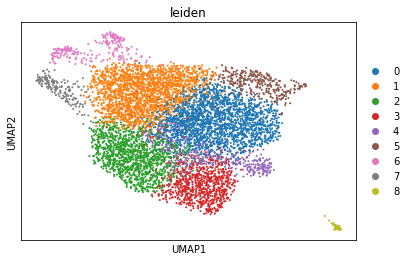

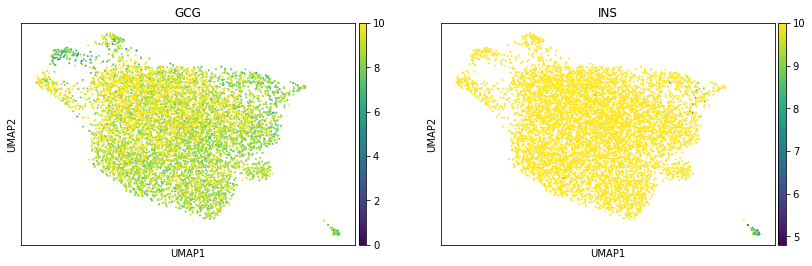

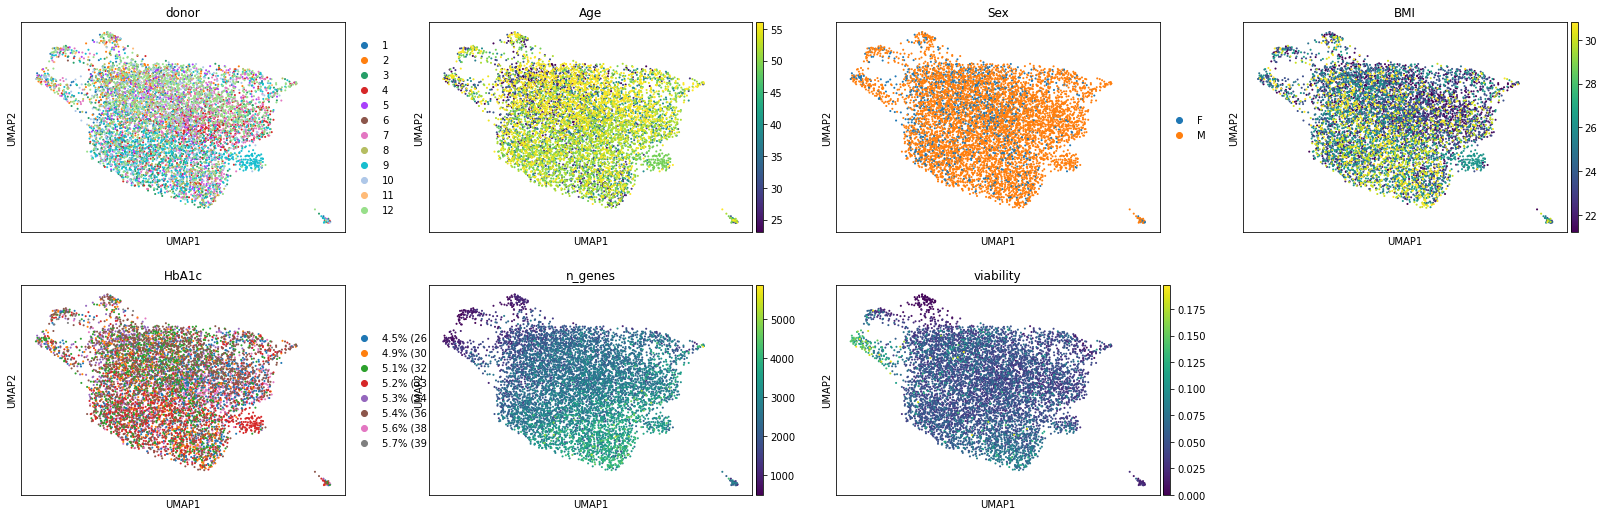

In [5]:
# Reprocess t cell data
dic_data_proc = {}
for ds in DS_LIST:
    print(ds)
    ind_select = (dic_data_raw[ds].obs['celltype']=='beta') 
    adata = dic_data_raw[ds][ind_select,:].copy()
    sc.pp.filter_cells(adata, min_genes=250)
    sc.pp.filter_genes(adata, min_cells=50)
    adata.obs['batch_harmony'] = adata.obs['donor']
    adata.obs['batch_harmony'] = adata.obs['batch_harmony'].astype('category')

    sc.pp.highly_variable_genes(adata, subset = False, min_disp=.5, 
                                min_mean=.0125, max_mean=10, n_bins=20, n_top_genes=None)
    sc.pp.scale(adata, max_value=10, zero_center=False)
    sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
    sc.external.pp.harmony_integrate(adata, key='batch_harmony', max_iter_harmony=20)
    sc.pp.neighbors(adata, n_neighbors=50, n_pcs=20, use_rep="X_pca_harmony")
#     sc.pp.neighbors(adata, n_neighbors=50, n_pcs=20, use_rep="X_pca")
    sc.tl.leiden(adata, resolution=0.7)   
    sc.tl.umap(adata)
    sc.pl.umap(adata, color='leiden')
    sc.pl.umap(adata, color=['GCG', 'INS'])
    sc.pl.umap(adata, color=['donor', 'Age', 'Sex', 'BMI', 'HbA1c', 'n_genes', 'viability'])
    adata.write('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/single_cell_data/tms_proc/'
                'pan_b.%s.h5ad'%ds)

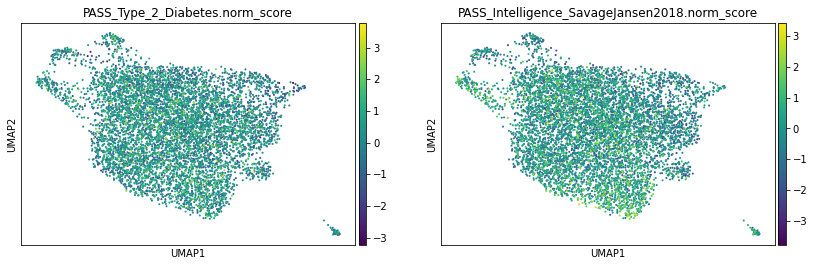

In [19]:
temp_data = adata.copy()
temp_data.obs = temp_data.obs.join(dic_score[ds][['%s.norm_score'%x for x in DIC_TRAIT_LIST[ds]]])
sc.pl.umap(temp_data, color=['%s.norm_score'%x for x in DIC_TRAIT_LIST[ds]])